## Tutorial1: Using SpatialMOSI for Mosaic Integration on Simulated Data

### 1. Preparation

In [6]:
import warnings
warnings.filterwarnings("ignore")
import SpatialMOSI

# the location of R (used for the mclust clustering)
import os
#os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
#os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

### 2. Load Data and Preprocess

In [7]:
from SpatialMOSI.utils import load_data
batch_list1, batch_list2,adj_list, csl_list = load_data(path='./Data/Dataset_SHARE_brain', slice_ids=['MERLSNARE','MERLSHARE'], omics=['RNA','CHR'],omics_HVGs=[10000,10000], radius=50,n_lsi=51)

graph includs edges: 24149 average edges per node: 7.905
Negative spots selection completed!
graph includs edges: 24149 average edges per node: 7.905
Negative spots selection completed!


In [8]:
from SpatialMOSI.utils import concat
adata_concat_adt=concat(batch_list2,adj_list,csl_list,slice_ids=['SHARE_ADT','SNARE_ADT'])
adata_concat_rna=concat(batch_list1,adj_list,csl_list,slice_ids=['SHARE_RNA','SNARE_RNA'])

concat matrix shape: (6110, 237)
concat matrix shape: (6110, 2985)


### 3. Train 

In [9]:
from SpatialMOSI.train import train_SpatialMOSI
train_SpatialMOSI(adata_concat_rna, adata_concat_adt, chr=True, pre_epochs=500, n_epochs=1000, hidden_dims_2=[40, 30], show=False, k_csps = 10,omics2_csps=True, device=used_device)

Pretraining...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.96it/s]


Training for multi slices...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:39<00:00, 12.67it/s]


### 4. Clustering 

In [ ]:
sc.pp.neighbors(adata_concat_rna, n_neighbors=50, use_rep = 'embedding_omics', key_added = 'neighbor')
sc.tl.umap(adata_concat_rna, neighbors_key = 'neighbor')
from sklearn.metrics import adjusted_rand_score as ari_score
sc.tl.leiden(adata_concat_rna, resolution=0.3, key_added='cluster',neighbors_key='neighbor')

In [11]:
print('mclust, ARI = %01.3f' % ari_score(adata_concat_rna.obs['layers'], adata_concat_rna.obs['cluster']))

mclust, ARI = 0.576


### 5. Visulization

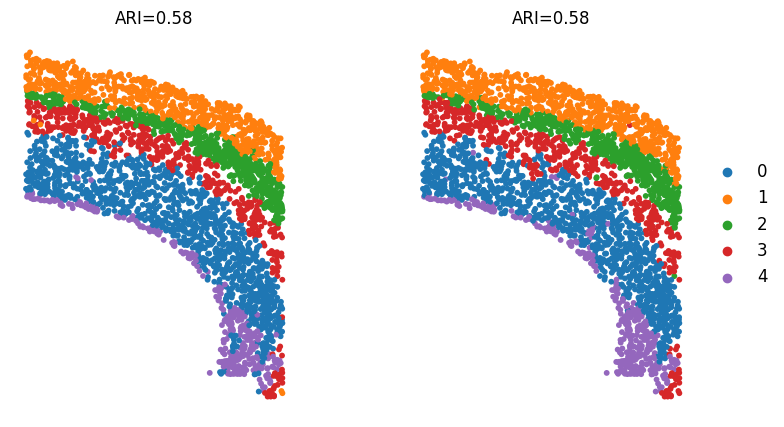

In [12]:
import scanpy as sc
Batch_list = []
section_ids=['SHARE_RNA','SNARE_RNA']
for section_id in section_ids:
    Batch_list.append(adata_concat_rna[adata_concat_rna.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt

title_size = 12
ARI_list = []
for bb in range(2):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['layers'], Batch_list[bb].obs['cluster']), 2))
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['cluster'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=50)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['cluster'], title=[''],
                       legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=50)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)

plt.show()

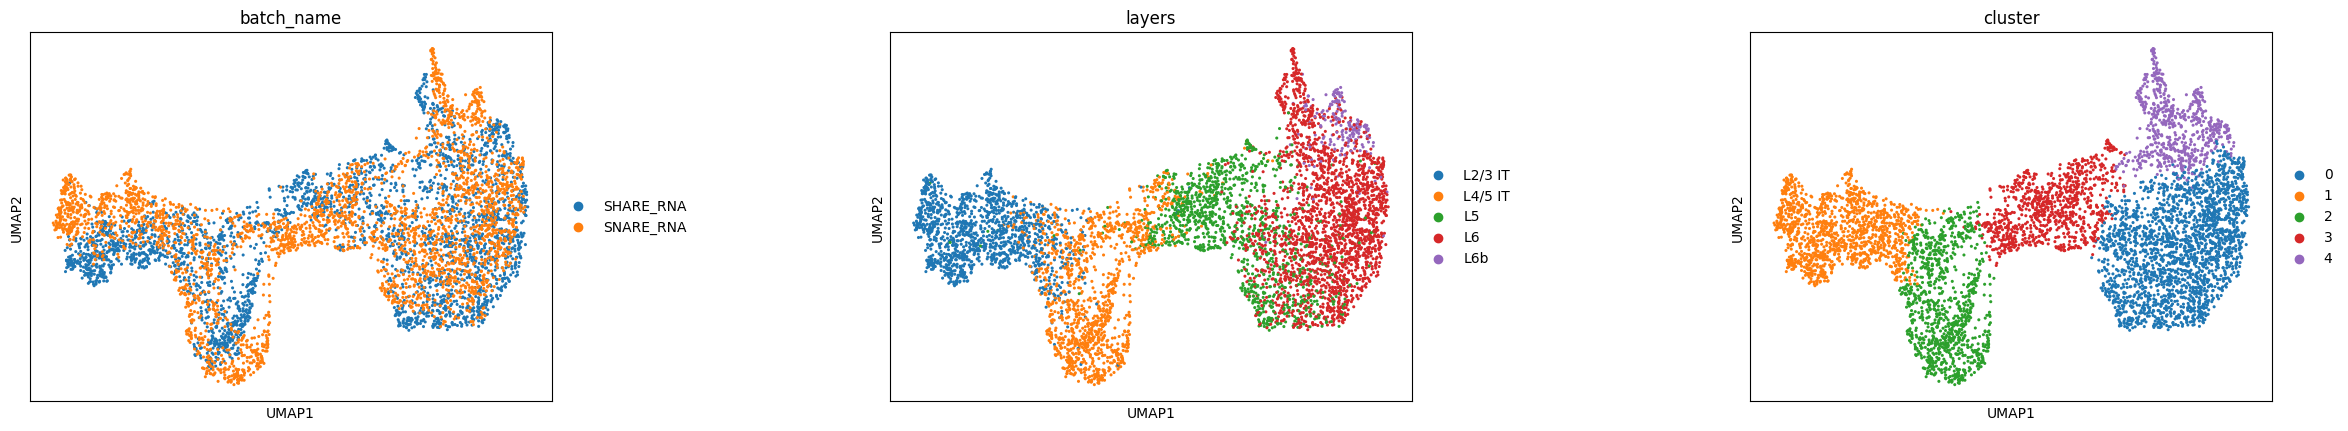

In [13]:
sc.pl.umap(adata_concat_rna, color=['batch_name', 'layers','cluster'], ncols=3, 
           wspace=0.5, show=True)